Léa ZADIKIAN - Février 2022
# Projet n° 6 : Classifier automatiquement des biens de consommation

**Objectif** : étudier la faisabilité d'un moteur de classification automatique de produits selon leurs catégories, à partir de de la description et de l'image du produit.
## Sommaire :
<a href="#C0">Imports et téléchargements </a>

* [Partie 1 : Traitements des données textuelles : description des produits](#partie1)
    * [1.1 Analyse exploratoire](#section_1_1)
   
    * [1.2 Pré-traitement des données textuelles](#section_1_2)
    
    * [1.3 Approche Bag Of Words ](#section_1_3)
        * [1.3.1 Approche Bag Of Words : comptage simple](#section_1_3_1)
        * [1.3.1 Approche Bag Of Words : TF-IDF](#section_1_3_1)
        
    * [1.4 Approche Word/Sentence Embedding](#section_1_4)
        * [1.4.1 Word Embedding classique avec Word2Vec](#section_1_4_1)
        * [1.4.2 Word Embedding avec BERT](#section_1_4_2)
        * [1.4.3 Sentence Embedding avec USE](#section_1_4_3)
    
    
* [Partie 2 : Traitement des données visuelles : image du produit](#partie2)
    * [2.1 Pré-traitement des données visuelles](#section_2_1)
    * [2.2 Approche SIFT](#section_2_2)
    * [2.3 Approche CNN Transfer learning](#section_2_3)


# <a name="C0">Imports et téléchargements</a>

In [1]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow==2.11.*

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.11.0-cp39-cp39-win_amd64.whl (1.9 kB)
  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.10.1
    Uninstalling tensorflow-2.10.1:
      

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.10.0 requires tensorflow<2.11,>=2.10.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.11.0 which is incompatible.


In [3]:
pip install tensorflow-text

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.10.1-cp39-cp39-win_amd64.whl (455.9 MB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successfully uninstalled tensorboard-2.11.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.11.0
    Uninstalling tensorflow-2.11.0:
    

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorboard<2.12,>=2.11, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-intel 2.11.0 requires tensorflow-estimator<2.12,>=2.11.0, but you have tensorflow-estimator 2.10.0 which is incompatible.


In [4]:
pip install --upgrade tensorflow-hub

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Imports

import os,time
from os import listdir
import random

# data
import random
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import missingno as msno
import string

# NLP
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer


# Tenserflow W2Vec
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

#Tenserflow VGG16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input


# Bert
import transformers
from transformers import AutoTokenizer

# BERT, USE
import tensorflow_hub as hub
import tensorflow_text as tf_text

# Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import manifold, decomposition
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Visualisation
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import plotly.express as px
from PIL import Image
from wordcloud import WordCloud
import cv2


In [8]:
# Téléchargements
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

[nltk_data] Downloading package punkt to C:\Users\Léa
[nltk_data]     Zadikian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Léa
[nltk_data]     Zadikian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Léa
[nltk_data]     Zadikian\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Léa
[nltk_data]     Zadikian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Partie 1 :  Traitement des données textuelles <a class="anchor" id="partie1"></a>

In [9]:
#Lecture et affichage du fichier 'flipkart_com-ecommerce_sample_1050'
data=pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
data

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

In [10]:
data.loc[data['uniq_id']=='55b85ea15a1536d46b7190ad6fff8ce7','product_url']

0    http://www.flipkart.com/elegance-polyester-mul...
Name: product_url, dtype: object

### 1.1 Analyse exploratoire <a class="anchor" id="section_1_1"></a>

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [12]:
print('Taux de remplissage du jeu de données : ', round(data.notna().mean().mean()*100,2),'%')

Taux de remplissage du jeu de données :  97.83 %


In [13]:
data.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

#### Observations des valeurs uniques prises par les variables catégorielles

In [14]:
print( 'product_name : \n\n' + str(data['product_name'].unique().tolist()))

product_name : 

['Elegance Polyester Multicolor Abstract Eyelet Door Curtain', 'Sathiyas Cotton Bath Towel', 'Eurospa Cotton Terry Face Towel Set', 'SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet', 'Jaipur Print Cotton Floral King sized Double Bedsheet', 'Maserati Time R8851116001 Analog Watch  - For Boys', 'Camerii WM64 Elegance Analog Watch  - For Men, Boys', 'T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys', 'Alfajr WY16B Youth Digital Watch  - For Men, Boys', 'TAG Heuer CAU1116.BA0858 Formula 1 Analog Watch  - For Boys, Men', 'Calibro SW-125 Analog-Digital Watch  - For Men, Boys', 'Cartier W6701005 Analog Watch  - For Boys, Men', 'Lois Caron LCS-4032 Analog Watch  - For Boys, Men', 'Titan 1639SL03 Analog Watch  - For Boys, Men', 'Srushti Art Jewelry Megnet_Led_Sport_BlackRed1 Digital Watch  - For Men, Women, Boys, Girls', 'Escort E-1700-906_Blk Analog Watch  - For Men, Boys', 'Jack klein BlackLed Digital Watch  - For Boys', 'North Moon IW-005-FK Silicone Ion Dig

In [15]:
print( 'product_category_tree : \n' + str(data['product_category_tree'].unique().tolist()))

product_category_tree : 
['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]', '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]', '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]', '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]', '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]', '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]', '["Watches >> Wrist Watches >> Camerii Wrist Watches"]', '["Watches >> Wrist Watches >> T STAR Wrist Watches"]', '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]', '["Watches >> Wrist Watches >> TAG Heuer Wrist Watches"]', '["Watches >> Wri

In [16]:
print( 'pid : \n' +str(data['pid'].unique().tolist()))

pid : 
['CRNEG7BKMFFYHQ8Z', 'BTWEGFZHGBXPHZUH', 'BTWEG6SHXTDB2A2Y', 'BDSEJT9UQWHDUBH4', 'BDSEJTHNGWVGWWQU', 'WATEAYAHJ8CUCAYM', 'WATE6Y6D2MZHWGBZ', 'WATECFFVGFZPAD3D', 'WATECHFU4QGFQEJG', 'WATEA6UGFGKZKDJC', 'WATECGPSDSFRHUSY', 'WATEAK8SE2RUK7GM', 'WATED53FKKH4S8E4', 'WATEDBVHQ6AJX7N9', 'WATEDFHARG4YSPCA', 'WATECDDDQ7SFDD6K', 'WATEAYZJBFJXB4FZ', 'WATE6GAQSZYB3FKY', 'WATE9M3RRRKZK4FD', 'WATE695YXNTDWTE8', 'WATE9MVXHMTCFZSP', 'WATECDB6HPXBVXCF', 'WATEBD3FJNXFXSBH', 'WATE9MVXDEVHGHAU', 'WATE9WKSHRYTM2PP', 'WATECGG4W76YEBUB', 'WATDQZGHJ9ARVGGK', 'WATEBYJABFE8WYTN', 'WATECSW5DJ3UBZYT', 'WATEC87GMAMZAMWA', 'WATE3GEYE8JQT7WM', 'WATEB2FZUMQU4W7R', 'WATECKYCCMXUQQMS', 'DSTEJJEXFWXKBDYM', 'DCVEJHVEMXYT6UF6', 'MATEB88TYRSSX8SH', 'AIREDJGYAHPBXTZS', 'JGTECTXNJJFCUCJK', 'BLBEJR23J2CTPFAU', 'CPCEJMM7HWCNNGBR', 'NSTEJHERS3AKXUCW', 'CPCEJMHZEHTQFACN', 'NSTEJMHARPK8BXHS', 'CNDEGVE65UWDPCYC', 'MUGEGZUHVZ4Y85DV', 'MUGEGZUHX744RFEN', 'MUGEGZUMNZCKBZYS', 'RTREGG8F83DMYHPE', 'MUGEGZUHAVSHPXST', 'CNDEGVE6PR9

In [17]:
print( 'is_FK_Advantage_product : \n' + str(data['is_FK_Advantage_product'].unique().tolist()))

is_FK_Advantage_product : 
[False, True]


In [18]:
print( 'description : \n\n' + str(data['description'].unique().tolist())+'\n')

description : 

['Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

In [19]:
print( 'product_rating : \n' + str(data['product_rating'].unique().tolist()))

product_rating : 
['No rating available', '5', '1', '2.3', '2.7', '4.5', '4', '3.8', '4.3', '3.7', '3.6', '3.5', '4.1', '4.9', '3.1', '4.2', '4.8', '4.4', '3.9', '3', '3.3', '2.5', '2', '4.7', '2.2', '3.2', '1.5']


In [20]:
print( 'overall_rating : \n' + str(data['overall_rating'].unique().tolist()))

overall_rating : 
['No rating available', '5', '1', '2.3', '2.7', '4.5', '4', '3.8', '4.3', '3.7', '3.6', '3.5', '4.1', '4.9', '3.1', '4.2', '4.8', '4.4', '3.9', '3', '3.3', '2.5', '2', '4.7', '2.2', '3.2', '1.5']


In [21]:
print( 'product_specifications : \n' + str(data['product_specifications'].unique().tolist()))

product_specifications : 
['{"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester Door Curtain Set Of 2"}, {"key"=>"Model ID", "value"=>"Duster25"}, {"key"=>"Color", "value"=>"Multicolor"}, {"key"=>"Length", "value"=>"213 cm"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 2"}, {"key"=>"Sales Package", "value"=>"2 Curtains"}, {"key"=>"Material", "value"=>"Polyester"}]}', '{"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "value"=>"Cotton"}, {"key"=>"Design", "value"=>"Self Design"}, {"key"=>"Brand", "value"=>"Sathiyas"}, {"key"=>"Type", "value"=>"Bath Towel"}, {"key"=>"GSM", "value"=>"500"}, {"key"=>"Model Name", "value"=>"Sathiyas cotton bath towel"}, {"key"=>"Ideal For", "value"=>"Men, Women, Boys, Girls"}, {"key"=>"Model ID", "value"=>"asvtwl322"}, {"key"=>"Color", "value"=>"Red, Yell

In [22]:
# print( 'brand : \n' + str(data['brand'].unique().tolist()))

In [23]:
# Concaténation de la colonne nom du produit et description, séparation par un espace.
data['_name_desc']=data['product_name'].str.cat(data['description'],sep=" ")
data['_name_desc'].unique().tolist()

['Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegan

**Présentation du jeu de données :**
* Le fichier CSV comporte 1050 lignes, chaque ligne est un produit.
* Le fichier comporte 15 colonnes, chaque colonne donnant des informations que le produits : nom, marque, description, prix, catégorie, url...

* Le jeu de données est très bien rempli ( plus de 98% de remplissage). Les quelques valeurs manquantes sont sur les colonnes :  prix, marque et spécifications. Il y a pas de de valeurs sur les colonnes qui nous interressent, à savoir uniq_id, product_name, image, description.
* La colonne product_category_tree donne l'arboresence complète du produit.Nous allons extraire la catégorie principale de chaque produit.

#### Extraction des catégories de produits

In [24]:
# On crée une nouvelle colonne qui contient la catégorie principale de l'article
# Il s'agit de la première catégorie dans l'arboresence fournie par la colonne product_category_tree
data['_main_category']=data['product_category_tree'].apply(lambda x: x.split(' >>')[0].split('["')[1])
data

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

In [25]:
# Liste des catégories principales de produits
main_categ_list=data['_main_category'].unique().tolist()
main_categ_list

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [26]:
# Nb de produits par catégories
data.groupby("_main_category").count()["uniq_id"]

_main_category
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
Name: uniq_id, dtype: int64

On obtient 7 catégories principales de produits, 150 produits par catégorie.

In [27]:
# Encodage des labels des catégories principales de produits avec une valeur entre 0 et le nb de catégorie -1
labelEncoder = LabelEncoder()
data['_main_category_num']=labelEncoder.fit_transform(data['_main_category'])
data['_main_category_num'].unique()

array([4, 0, 6, 3, 5, 1, 2])

In [28]:
# On récupère également la "sous catégorie"
# Il s'agit de la 2ème catégorie dans l'arboresence fournie dans la colonne product_category_tree
data['_second_category']=data['product_category_tree'].apply(lambda x: x.split('>>')[1])
#data

In [29]:
# Nombre de sous catégorie
data['_second_category'].nunique()

63

Les 1050 produits "Place de marché" sont réparties équitablement dans 7 catégories principales différentes, avec 150 produits dans chacune des catégories suivantes : 
* Baby Care                   
* Beauty and Personal Care 
* Computers 
* Home Decor & Festive Needs 
* Home Furnishing  
* Kitchen & Dining  
* Watches     

#### Création d'un nuage de mots

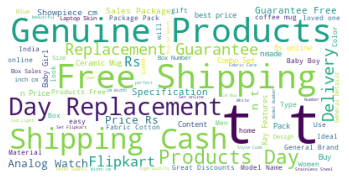

In [30]:
# Nuage de mot sur l'ensemble des noms et description de produits
corpus=str(data['_name_desc'].tolist()) # Définition du  Corpus
wordcloud=WordCloud(background_color='white',max_words=80).generate(corpus)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

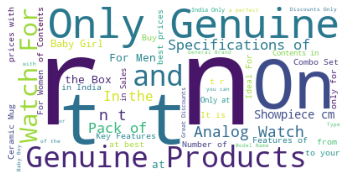

In [31]:
# Nuage de mots en excluant les mots communs aux produits

# Mots à exlure du nuage de mots (en général communs aux produits)
exclure=['shipping','free','flipkart','product','price','package','delivery',"delivery'",'discount',
         'cash','replacement','guarantee',"guarantee'",'day','rs','com','online']
# Définition du  Corpus
corpus=str(data['_name_desc'].tolist())
wordcloud=WordCloud(background_color='white',stopwords=exclure,max_words=50).generate(corpus)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

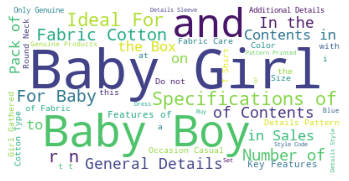

In [32]:
# Nuage de mots sur une catégories de produits données

# Mots à exlure du nuage de mots (en général communs aux produits)
exclure=['shipping','free','flipkart','product','price','package','delivery',"delivery'",'discount',
         'cash','replacement','guarantee',"guarantee'",'day','rs','com','online']
# Définition du  Corpus
corpus=str(data.loc[data['_main_category']=="Baby Care",'_name_desc'].tolist()) # Sur la catégorie Baby Care
wordcloud=WordCloud(background_color='white',stopwords=exclure,max_words=50).generate(corpus)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

### 1.2 Pré-traitement des données textuelles <a class="anchor" id="section_1_2"></a>
L'objectif est de mettre en place les différentes fonctions de nettoyage des données textes avant leur transformations :
* Tokenization
* Suppression des stops words
* Lemmatisation

In [33]:
# Mise en place de focntions de nettoyage du texte

# Tokenizer (découpage en mots)
def tokenizer_fct(sentence) :
    print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Création de la liste des stop words (suppression des "petis mots" (mots peu informatifs) et de la ponctuation )
stop_words = list(set(stopwords.words('english'))) 
ponctuation =set(string.punctuation) # liste des signes de ponctuation
stop_words.extend(ponctuation)

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_words] # On garde les tokens qui ne sont pas dans la liste des stopwords
    filtered_w2 = [w for w in filtered_w if len(w) > 2] # Parmi, les tokens restant,on garde des tokens qui ont plus de 2 lettres
    #filtered_w3 = [w for w in filtered_w2 if not any(chr.isdigit() for chr in w)] # Parmi, les tokens restant,on garde des tokens ne contiennent pas de chiffres
    return filtered_w2

# Lemmatisation (base d'un mot)
def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Racinisation (stemming, racise du mot)
def stem_fct(list_words) :
    stemmer=PorterStemmer()
    stem_w=[stemmer.stem(w) for w in list_words]
    return stem_w

# Fonction de pré-traitement du texte pour l'approche bag of words et Word2Vec
def transform_bow_fct(text) :
    lower = text.lower() # passage en minuscule
    word_tokens = tokenizer_fct(lower) # tokenisation
    sw = stop_word_filter_fct(word_tokens) # supression des stop words
    lem_w = lemma_fct(sw)    # lemmatisation
    transformed_text = ' '.join(lem_w)
    return transformed_text

# Fonction de pré-traitement du texte pour le deep learning ( BERT et USE)
def transform_dl_fct(text) :
    lower = text.lower() # passage en minuscule
    word_tokens = tokenizer_fct(lower) # tokenisation
    #sw = stop_word_filter_fct(word_tokens) # supression des stop words
    #lem_w = lemma_fct(word_tokens)    # lemmatisation
    transformed_text = ' '.join(word_tokens)
    return transformed_text


In [34]:
# Affichage de la liste des stop words
stop_words

['isn',
 'wasn',
 "doesn't",
 'aren',
 'by',
 'shan',
 'those',
 'just',
 "isn't",
 'until',
 "you've",
 'didn',
 'needn',
 "you'll",
 'themselves',
 'hasn',
 'off',
 'we',
 'about',
 're',
 'ours',
 'me',
 'now',
 "you'd",
 'hers',
 'most',
 'yours',
 'such',
 't',
 'hadn',
 'so',
 'no',
 'yourself',
 "should've",
 'doing',
 'few',
 "needn't",
 'ain',
 'wouldn',
 'more',
 'but',
 'into',
 'over',
 'the',
 'same',
 'mightn',
 'this',
 "didn't",
 'itself',
 'himself',
 "shan't",
 'what',
 'with',
 "she's",
 'had',
 'has',
 'because',
 'can',
 'd',
 'very',
 'each',
 'my',
 'why',
 "couldn't",
 'been',
 'having',
 'or',
 'will',
 'its',
 'against',
 'of',
 'out',
 'don',
 'll',
 'they',
 'these',
 'while',
 'there',
 'doesn',
 'to',
 'myself',
 'through',
 'here',
 'under',
 'them',
 'which',
 'do',
 'further',
 'too',
 'is',
 'i',
 'some',
 'any',
 "mightn't",
 "you're",
 'nor',
 'o',
 'after',
 'y',
 'm',
 'should',
 'weren',
 'yourselves',
 "aren't",
 'her',
 'herself',
 'between',
 '

In [35]:
# Création d'une colonne sur laquelle on applique la fonction de pré-traitement du texte ( nettoyage )
data['_name_desc_bow'] = data['_name_desc'].apply(lambda x : transform_bow_fct(x))

elegance polyester multicolor abstract eyelet door curtain key features of elegance polyester multicolor abstract eyelet door curtain floral curtain,elegance polyester multicolor abstract eyelet door curtain (213 cm in height, pack of 2) price: rs. 899 this curtain enhances the look of the interiors.this curtain is made from 100% high quality polyester fabric.it features an eyelet style stitch with metal ring.it makes the room environment romantic and loving.this curtain is ant- wrinkle and anti shrinkage and have elegant apparance.give your home a bright and modernistic appeal with these designs. the surreal attention is sure to steal hearts. these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. bring home the elegant 

tirupati 4"- green wheel pizza cutter buy tirupati 4"- green wheel pizza cutter for rs.649 online. tirupati 4"- green wheel pizza cutter at best prices with free shipping & cash on delivery. only genuine products. 30 day replacement guarantee.
shoppingtara elephant pair gift showpiece  -  4 cm buy shoppingtara elephant pair gift showpiece  -  4 cm for rs.519 online. shoppingtara elephant pair gift showpiece  -  4 cm at best prices with free shipping & cash on delivery. only genuine products. 30 day replacement guarantee.
orange tree dune wall decor set of 3 showpiece  -  8 cm orange tree dune wall decor set of 3 showpiece  -  8 cm (iron, gold)
                         price: rs. 1,529
				
			metal saucer with a hand-worked look floats a classic round mirror in the center. these set of 3 in dark ant. brass finish lets your imagination loose by creating interesting combinations on any wall surface
metal saucer with a hand-worked look floats a classic round mirror in the center. these se

lapguard dell u661h compatible black 6 cell laptop battery buy lapguard dell u661h compatible black 6 cell laptop battery only for rs. 1799 from flipkart.com. only genuine products. 30 day replacement guarantee. free shipping. cash on delivery!
rega it hp pavilion dv6-6080sf dv6-6081ei 12 cell 12 cell laptop battery buy rega it hp pavilion dv6-6080sf dv6-6081ei 12 cell 12 cell laptop battery only for rs. 2499 from flipkart.com. only genuine products. 30 day replacement guarantee. free shipping. cash on delivery!
lapguard hp pavilion dv4129ea compatible black 6 cell laptop battery buy lapguard hp pavilion dv4129ea compatible black 6 cell laptop battery only for rs. 1699 from flipkart.com. only genuine products. 30 day replacement guarantee. free shipping. cash on delivery!
hp compaq presario cq43 6 cell laptop battery buy hp compaq presario cq43 6 cell laptop battery only for rs. 0.0 from flipkart.com. only genuine products. 30 day replacement guarantee. free shipping. cash on delivery!

perucci pc-303 analog watch  - for men perucci pc-303 analog watch  - for men - buy perucci pc-303 analog watch  - for men  pc-303 online at rs.1295 in india only at flipkart.com. - great discounts, only genuine products, 30 day replacement guarantee, free shipping. cash on delivery!
perucci pc-310 analog watch  - for men perucci pc-310 analog watch  - for men - buy perucci pc-310 analog watch  - for men  pc-310 online at rs.1395 in india only at flipkart.com. - great discounts, only genuine products, 30 day replacement guarantee, free shipping. cash on delivery!
chappin & nellson cnl-50-white-rg analog watch  - for women chappin & nellson cnl-50-white-rg analog watch  - for women - buy chappin & nellson cnl-50-white-rg analog watch  - for women  cnl-50-white-rg online at rs.799 in india only at flipkart.com. - great discounts, only genuine products, 30 day replacement guarantee, free shipping. cash on delivery!
nutcase sticker wrap design - teal & pink watercolors 800 ml bottle nutcas

sj tulip multi use cotton balls specifications of sj tulip multi use cotton balls (pack of 100) general traits number of pieces per pack 100 ideal for girls in the box 100 cotton balls
ech oly ceramic inside fitting hookah mouth tip ech oly ceramic inside fitting hookah mouth tip (black) price: rs. 699 durable and can be used repeatedly for a long time. made of high-quality special material. does not contain harmful objects. the rubber ring can prevent smoke and tar from leaking. remove tar while using for about 20 times. replace with an auxiliary rubber ring if damages.,specifications of ech oly ceramic inside fitting hookah mouth tip (black) general brand ech oly model number durable tobacco pipe b117 type inside fitting material ceramic pack of 1 color black in the box pack of 1
lawman pg3 striker,, winger , contender deodorant spray  -  for men key features of lawman pg3 striker,, winger , contender deodorant spray  -  for men fragrance classification: deodorant spray,lawman pg3 st

In [36]:
# Création d'une colonne sur laquelle on applique la fonction de pré-traitement du texte ( nettoyage )
data['_name_desc_dl'] = data['_name_desc'].apply(lambda x : transform_dl_fct(x))

elegance polyester multicolor abstract eyelet door curtain key features of elegance polyester multicolor abstract eyelet door curtain floral curtain,elegance polyester multicolor abstract eyelet door curtain (213 cm in height, pack of 2) price: rs. 899 this curtain enhances the look of the interiors.this curtain is made from 100% high quality polyester fabric.it features an eyelet style stitch with metal ring.it makes the room environment romantic and loving.this curtain is ant- wrinkle and anti shrinkage and have elegant apparance.give your home a bright and modernistic appeal with these designs. the surreal attention is sure to steal hearts. these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. bring home the elegant 

toddla baby girl's gathered dress key features of toddla baby girl's gathered dress raglan printed dress with beautiful flower on waist. lining 100% cotton. toddla gathered a-line cotton floral print knee-longdress for baby girls material : made up of  cotton that make this dress very comfortable to wear all day long . the perfrect dress for little princess to carry her cuteness and style . wash care : normal wash in cold water . do not twist . do not tumble .dry in shade .,toddla baby girl's gathered dress price: rs. 499 raglan printed dress with beautiful flower on waist. lining 100% cotton.,specifications of toddla baby girl's gathered dress in the box 1 frock dimensions length midi/knee length general details pattern floral print ideal for baby girl's occasion casual dress details sleeve sleeveless number of contents in sales package pack of 1 fabric cotton type gathered neck crew neck additional details other details product weight (g) -200, product length (cm) -23
baby moshai bab

trendnet n150 wireless adsl 2 modem router buy trendnet n150 wireless adsl 2 modem router only for rs. 0.0 from flipkart.com. only genuine products. 30 day replacement guarantee. free shipping. cash on delivery!
binatone wr3000n buy binatone wr3000n only for rs. 1800 from flipkart.com. only genuine products. 30 day replacement guarantee. free shipping. cash on delivery!
kamasutra combo offer pack combo set flipkart.com: buy kamasutra combo offer pack combo set online only for rs. 380 from flipkart.com. only genuine products. 30 day replacement guarantee. free shipping. cash on delivery!
tenda a5 buy tenda a5 only for rs. 2250 from flipkart.com. only genuine products. 30 day replacement guarantee. free shipping. cash on delivery!
d-link dir-816 wireless ac750 dual band router buy d-link dir-816 wireless ac750 dual band router only for rs. 3999 from flipkart.com. only genuine products. 30 day replacement guarantee. free shipping. cash on delivery!
arabian nights evolve combo set flipkart

oriflame sweden sun zone uv protector face and exposed areas high - spf 50 pa++ flipkart.com: buy oriflame sweden sun zone uv protector face and exposed areas high - spf 50 pa++ for rs. 699 from flipkart.com. - lowest prices, only genuine products, 30 day replacement guarantee, free shipping. cash on delivery!
aveeno protect + hydrate broad spectrum spf 70 sunscreen lotion - spf 70 pa+ flipkart.com: buy aveeno protect + hydrate broad spectrum spf 70 sunscreen lotion - spf 70 pa+ for rs. 1389 from flipkart.com. - lowest prices, only genuine products, 30 day replacement guarantee, free shipping. cash on delivery!
la roche-posay anthelios xl fluid dry touch gel-cream - spf 50 pa+ flipkart.com: buy la roche-posay anthelios xl fluid dry touch gel-cream - spf 50 pa+ for rs. 1400 from flipkart.com. - lowest prices, only genuine products, 30 day replacement guarantee, free shipping. cash on delivery!
wallmantra christ the redeemer framed print canvas painting wallmantra christ the redeemer fra

home originals geometric, striped double blanket multicolor buy home originals geometric, striped double blanket multicolor at rs. 1299 at flipkart.com. only genuine products. free shipping. cash on delivery!
sapatos plain single duvet blue sapatos plain single duvet blue (1 piece brown single duvet)
                         price: rs. 1,499
				
			add spunk to your home decor with this beautifully designed duvet from sapatos. crafted to provide utmost comfort, this exquisite quilt will ensure that you look forward to crash into bed after a tiring day.
add spunk to your home decor with this beautifully designed duvet from sapatos. crafted to provide utmost comfort, this exquisite quilt will ensure that you look forward to crash into bed after a tiring day.
home originals abstract double quilts & comforters multicolor buy home originals abstract double quilts & comforters multicolor at rs. 1199 at flipkart.com. only genuine products. free shipping. cash on delivery!
pompom sweethearts 

print shapes peacock feather laptop skin with mouse pad combo set key features of print shapes peacock feather laptop skin with mouse pad combo set glue free removal 15.6 inches laptop skin easy to apply & scratch resistant lamination,print shapes peacock feather laptop skin with mouse pad combo set (multicolor) price: rs. 329 print shapes laptop skin made on high quality vinyl sheet is compatible with laptops screen sizes ranging from 14.1 inches to 15.6 inches. trimning of the skin would be required as per your laptop size. the skins are easy to install & remove without leaving any gum or residue,specifications of print shapes peacock feather laptop skin with mouse pad combo set (multicolor) general brand print shapes model name peacock feather laptop skin with mouse pad suitable_for all types of laptop color multicolor warranty warranty summary no warranty in the box number of contents in sales package pack of 2
print shapes despicable me 2 looking upwards laptop skin with mouse pad

In [37]:
data

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

In [38]:
# Affichage d'un exemple de nom + description de produits
data['_name_desc'][104]

'Rama Floral Single Quilts & Comforters Yellow Buy Rama Floral Single Quilts & Comforters Yellow at Rs. 749 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!'

In [39]:
# Test sur cet exemple la bonne réalisation des fonctions de nettoyage, pour l'approche bag of words
data['_name_desc_bow'][104]

'rama floral single quilt comforter yellow buy rama floral single quilt comforter yellow 749 flipkart.com genuine product free shipping cash delivery'

In [40]:
# test sur l'exemple de la bonne réalisation des fonctions de nettoyage, pour l'approche word enbedding
data['_name_desc_dl'][104]

'rama floral single quilts & comforters yellow buy rama floral single quilts & comforters yellow at rs . 749 at flipkart.com . only genuine products . free shipping . cash on delivery !'

### 1.3 Approche Bag of words <a class="anchor" id="section_1_3"></a>
* Bag of words : Description de l'occurence des mots dans un document.

* Document-term matrix : describes the frequency of terms that occur in a collection of documents. Size of the document-term matrix : number of documents ∗ size of vocabulary

* Avantages : simple
* Inconvénient : on perd l'ordre des mots. Vecteurs creux, pb quand la dimension augmente.


#### 1.3.1 Approche Bag of words comptage simple de mots <a class="anchor" id="section_1_3_1"></a>

In [41]:
# création du bag of words comptage simple de mots (CountVectorizer)
X = data['_name_desc_bow'].values

countVect = CountVectorizer(stop_words=stop_words, max_df=0.95, min_df=1) # max_df :corpus-specific stop words ignore les termes trop fréquents (ds les documents)
X_cv = countVect.fit_transform(X)
X_cv.shape

(1050, 5420)

In [42]:
# Affichage de la matrice documents - termes
vocab = countVect.get_feature_names_out()
docterm = pd.DataFrame(X_cv.todense(), columns=vocab)
docterm

000  001  0021  004  005  006  0083  011  01433cmgy  01727lpln  ...  \
0       0    0     0    0    0    0     0    0          0          0  ...   
1       0    0     0    0    0    0     0    0          0          0  ...   
2       0    0     0    0    0    0     0    0          0          0  ...   
3       0    0     0    0    0    0     0    0          0          0  ...   
4       0    0     0    0    0    0     0    0          0          0  ...   
...   ...  ...   ...  ...  ...  ...   ...  ...        ...        ...  ...   
1045    0    0     0    0    0    0     0    0          0          0  ...   
1046    0    0     0    0    0    0     0    0          0          0  ...   
1047    0    0     0    0    0    0     0    0          0          0  ...   
1048    0    0     0    0    0    0     0    0          0          0  ...   
1049    0    0     0    0    0    0     0    0          0          0  ...   

      zinc  zingalalaa  zip  zipexterior  zipper  zippered  zone  zoom  zora  \
0        0           0    0            0       0         0     0     0     0   
1        0           0    0            0       0         0     0     0     0   
2        0           0    0            0       0         0     0     0     0   
3        0           0    0            0       0         0     0     0     0   
4        0           0    0            0       0         0     0     0     0   
...    ...         ...  ...          ...     ...       ...   ...   ...   ...   
1045     0           0    0            0       0         0     0     0     0   
1046     0           0    0            0       0         0     0     0     0   
1047     0           0    0            0       0         0     0     0     0   
1048     0           0    0            0       0         0     0     0     0   
1049     0           0    0            0       0         0     0     0     0   

      zyxel  
0         0  
1         0  
2         0  
3         0  
4         0  
...     ...  
1045      0  
1046      0  
1047      0  
1048      0  
1049      0  

[1050 rows x 5420 columns]

#### Réduction de dimension ACP
*(Ressources : cours Openclassrooms : Introduction to Natural Language Processing)*

The vocabulary is the set of all unique tokens in a corpus. Its size directly impacts the dimension of the document-term matrix. Therefore, reducing its size is essential to avoid performing calculations over gigantic matrices.

While removing stopwords and lemmatizing helps reduce the vocabulary size significantly, it’s often not enough.
Therefore, reducing the size of the vocabulary is crucial. The idea is to remove as many tokens as possible without throwing away relevant information. It’s a delicate balance that is entirely dependent on the context. One strategy can be to filter out words that are either too frequent or too rare. Another process involves applying dimension reduction techniques (PCA) to the document-term matrix. 
It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.

* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [43]:
txt_features =X_cv.todense()
print("Dimensions dataset avant réduction PCA : ", txt_features.shape)

Dimensions dataset avant réduction PCA :  (1050, 5420)


In [44]:
# Standardisation des données
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(np.asarray(txt_features))

In [45]:
# Réduction de dimensions ACP, on conserve 99% de la variance expliquée.
pca = decomposition.PCA(n_components=0.99)
X_pca= pca.fit_transform(np.asarray(txt_features))
print("Dimensions dataset après réduction PCA : ", X_pca.shape)

Dimensions dataset après réduction PCA :  (1050, 758)


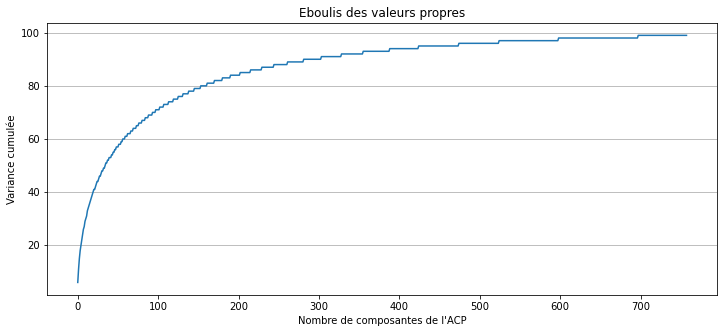

In [46]:
# Variance captée par chaque nouvelle composante
scree = (pca.explained_variance_ratio_*100).round(2)

# Variance retenue cumulée
scree_cum = scree.cumsum().round()

#Représentation graphique de la variance retenue cumuléz
plt.figure(figsize=(12,5))
plt.plot(range(len(scree)), scree_cum)
plt.xlabel('Nombre de composantes de l\'ACP')
plt.ylabel('Variance cumulée')
plt.title("Eboulis des valeurs propres");
plt.grid(axis='y')



#### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D

t-SNE, pour “t-distributed Stochastic Neighbor Embedding”. (pour loi t de Student) une des méthodes de visualisation les plus usitées actuellement.
Cette technique permet de visualiser des données de (très) grandes dimensions, en effectuant un plongement (embedding, en anglais) dans une variété de plus petite dimension, généralement 2 ou 3 pour pouvoir repérer des caractéristiques intéressantes du phénomène à modéliser. Elle est devenue populaire pour sa capacité à générer des visualisations très parlantes.

In [47]:
# Calcul du tsne
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     learning_rate=200,
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# création d'un df avec les données du tsne 
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["category"] = data["_main_category"] # ajout de la colonne correspondant à la vraie catégorie de chaque produit
df_tsne

tsne1      tsne2         category
0     10.643977 -33.513508  Home Furnishing
1     12.509524 -11.439615        Baby Care
2     15.030598  -6.414041        Baby Care
3     11.828779 -20.501045  Home Furnishing
4     11.388212 -20.916048  Home Furnishing
...         ...        ...              ...
1045 -12.592017 -17.730316        Baby Care
1046 -13.293551 -13.652551        Baby Care
1047 -16.137074 -14.213819        Baby Care
1048 -13.824223 -12.525960        Baby Care
1049 -15.709203 -13.268386        Baby Care

[1050 rows x 3 columns]

#### Représentation graphique, après réduction t-SNE, des produits selon les "vraies" catégories de produits.

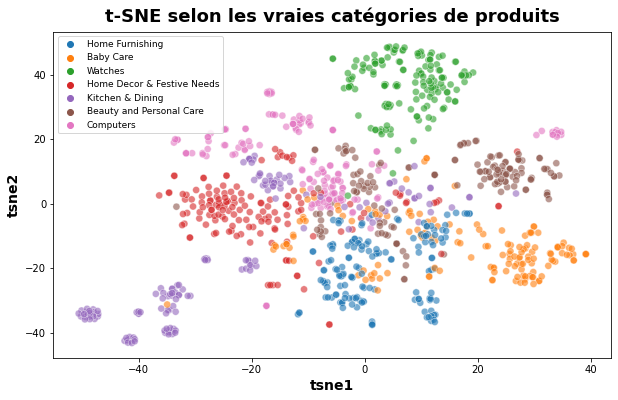

In [48]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="category", data=df_tsne, legend='brief',
    palette=sns.color_palette('tab10', n_colors=len(main_categ_list)), 
    s=50, alpha=0.6
    )

plt.title('t-SNE selon les vraies catégories de produits', fontsize = 18, pad = 10, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
plt.legend(prop={'size': 9},loc='best') 

plt.show()

In [49]:
# Détermination des clusters à partir des données du t-sne 
cls = KMeans(n_clusters=len(main_categ_list),n_init=100, random_state=42)
cls.fit(X_tsne)
df_tsne['cluster'] = cls.labels_

C:\Users\Léa Zadikian\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


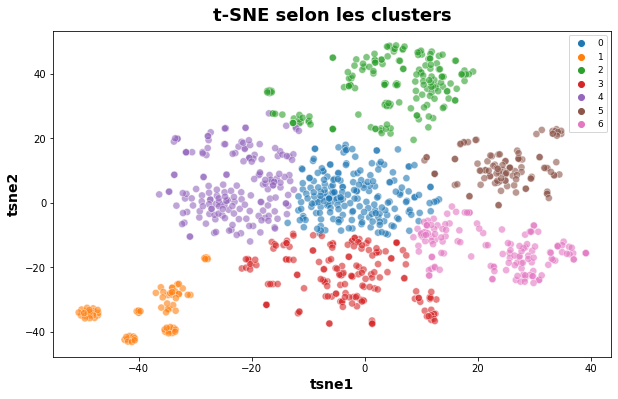

In [50]:
# Affichage des produits selon les clusters
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",hue='cluster',
    palette=sns.color_palette('tab10', n_colors=len(main_categ_list)), 
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('t-SNE selon les clusters', fontsize = 18, pad = 10, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
plt.legend(prop={'size': 9}) 

plt.show()


#### Score ARI - similarité entre clusters et vraies catégories

In [51]:
ARI = np.round(metrics.adjusted_rand_score(data["_main_category_num"], cls.labels_),4)
print("Score ARI Bag of words comptage simple: ", np.round(metrics.adjusted_rand_score(data["_main_category_num"].values, cls.labels_),4))

Score ARI Bag of words comptage simple:  0.4287


#### 1.3.2 Approche Bag of words TF-IDF (Term-Frequency Iverse Document Frequency) <a class="anchor" id="section_1_3_2"></a>
* Normalisation des données : réduit l'importance des termes présents partout et fait ressortir les termes discriminants.A tf-idf score is a decimal number that measures the importance of a word in any document. It gives small values to frequent words across the corpus and larger values to less common ones. 

* The problem with counting word occurrences is that some words appear only in a limited number of documents. The model will learn that pattern, overfit the training data, and fail to generalize to new texts properly. Similarly, words that are present in all the documents will not bring any information to the classification model.

* For this reason, it is sometimes better to normalize the word counts by the number of times they appear in the documents.

* Tf : term frequency, the number of times the word appears in each document. ( with  CountVectorizer  )

* Idf : for inverse document frequency, an inverse count of the number of documents a word appears in. Idf measures how significant a word is in the whole corpus.

In [133]:
#Création de TF-Idf
X = data['_name_desc_bow'].values
tfidfVect = TfidfVectorizer(stop_words=stop_words, max_df=0.95, min_df=1)
X_tfidf = tfidfVect.fit_transform(X)
X_tfidf.shape

(1050, 5420)

In [134]:
txt_features =X_tfidf.todense()
print("Dimensions dataset avant réduction PCA : ", txt_features.shape)
# Standardisation des données
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(np.asarray(txt_features))
# Réduction de dimensions ACP, on conserve 99% de la variance expliquée.
pca = decomposition.PCA(n_components=0.99)
X_pca= pca.fit_transform(np.asarray(txt_features))
print("Dimensions dataset après réduction PCA : ", X_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 5420)
Dimensions dataset après réduction PCA :  (1050, 899)


In [135]:
# Affichage de la matrice terme-document tf-idf
vocab = tfidfVect.get_feature_names_out()
docterm = pd.DataFrame(X_tfidf.todense(), columns=vocab)
docterm

000  001  0021  004  005  006  0083  011  01433cmgy  01727lpln  ...  \
0     0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0        0.0        0.0  ...   
1     0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0        0.0        0.0  ...   
2     0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0        0.0        0.0  ...   
3     0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0        0.0        0.0  ...   
4     0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0        0.0        0.0  ...   
...   ...  ...   ...  ...  ...  ...   ...  ...        ...        ...  ...   
1045  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0        0.0        0.0  ...   
1046  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0        0.0        0.0  ...   
1047  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0        0.0        0.0  ...   
1048  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0        0.0        0.0  ...   
1049  0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0        0.0        0.0  ...   

      zinc  zingalalaa  zip  zipexterior  zipper  zippered  zone  zoom  zora  \
0      0.0         0.0  0.0          0.0     0.0       0.0   0.0   0.0   0.0   
1      0.0         0.0  0.0          0.0     0.0       0.0   0.0   0.0   0.0   
2      0.0         0.0  0.0          0.0     0.0       0.0   0.0   0.0   0.0   
3      0.0         0.0  0.0          0.0     0.0       0.0   0.0   0.0   0.0   
4      0.0         0.0  0.0          0.0     0.0       0.0   0.0   0.0   0.0   
...    ...         ...  ...          ...     ...       ...   ...   ...   ...   
1045   0.0         0.0  0.0          0.0     0.0       0.0   0.0   0.0   0.0   
1046   0.0         0.0  0.0          0.0     0.0       0.0   0.0   0.0   0.0   
1047   0.0         0.0  0.0          0.0     0.0       0.0   0.0   0.0   0.0   
1048   0.0         0.0  0.0          0.0     0.0       0.0   0.0   0.0   0.0   
1049   0.0         0.0  0.0          0.0     0.0       0.0   0.0   0.0   0.0   

      zyxel  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
...     ...  
1045    0.0  
1046    0.0  
1047    0.0  
1048    0.0  
1049    0.0  

[1050 rows x 5420 columns]

In [136]:
# Calcul du tsne
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     learning_rate=200,
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# création d'un df avec les données du tsne 
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["category"] = data["_main_category"] # ajout de la colonne correspondant à la vraie catégorie de chaque produit
df_tsne

tsne1      tsne2         category
0      0.954382  31.039406  Home Furnishing
1     -6.697587  51.033314        Baby Care
2    -10.195909  52.238831        Baby Care
3      8.093552  39.596966  Home Furnishing
4      7.714569  39.323425  Home Furnishing
...         ...        ...              ...
1045  -5.055168 -15.929614        Baby Care
1046  -3.122236 -16.009962        Baby Care
1047  -0.076101 -14.104072        Baby Care
1048  -0.784227 -16.558861        Baby Care
1049  -0.216026 -14.780348        Baby Care

[1050 rows x 3 columns]

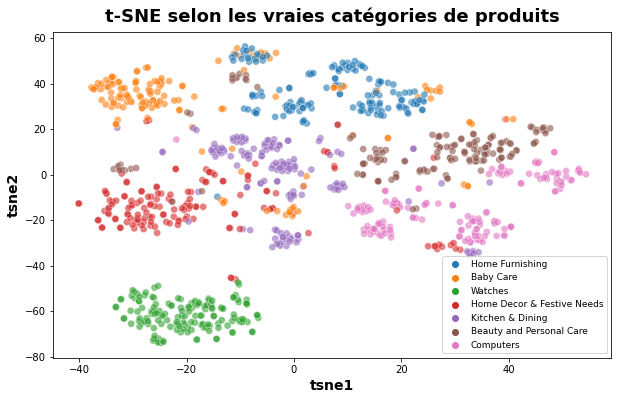

In [137]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="category", data=df_tsne, legend='brief',
    palette=sns.color_palette('tab10', n_colors=len(main_categ_list)), 
    s=50, alpha=0.6
    )

plt.title('t-SNE selon les vraies catégories de produits', fontsize = 18, pad = 10, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
plt.legend(prop={'size': 9},loc='best') 

plt.show()

In [138]:
 # Détermination des clusters à partir des données Tsne 
cls = KMeans(n_clusters=len(main_categ_list),n_init=100, random_state=42)
cls.fit(X_tsne)
df_tsne['cluster'] = cls.labels_

C:\Users\Léa Zadikian\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


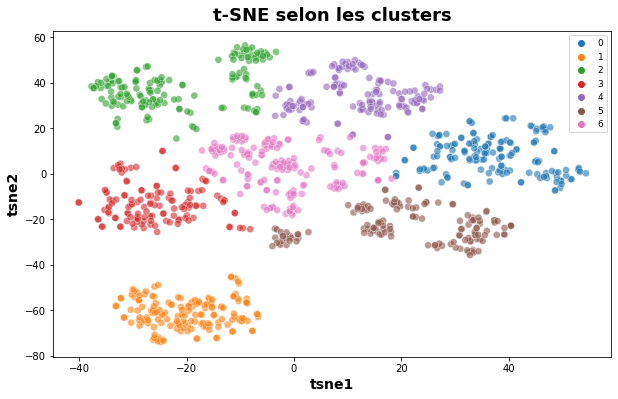

In [139]:
# Affichage des produits selon les clusters
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",hue='cluster',
    palette=sns.color_palette('tab10', n_colors=len(main_categ_list)), 
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('t-SNE selon les clusters', fontsize = 18, pad = 10, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
plt.legend(prop={'size': 9}) 

plt.show()


In [140]:
ARI = np.round(metrics.adjusted_rand_score(data["_main_category_num"], cls.labels_),4)
print("Score ARI, approche Bag Of words, tf-idf : ", np.round(metrics.adjusted_rand_score(data["_main_category_num"].values, cls.labels_),4))

Score ARI, approche Bag Of words, tf-idf :  0.5466


#### Analyse par classe
* La matrice de confusion doit être transformée pour avoir en colonne le même ordre des catégories supposées qu'en ligne.

In [60]:
# Nombre de produit par clusters
df_tsne.groupby("cluster").count()["category"]

cluster
0    159
1    153
2    155
3    128
4    138
5    145
6    172
Name: category, dtype: int64

In [61]:
conf_mat = metrics.confusion_matrix(data["_main_category_num"], cls.labels_)
print(conf_mat)

[[  8   0 106   4  17   0  15]
 [ 99   0  12  11   2   2  24]
 [ 47   0   1   0   0 102   0]
 [  1   3   2 106   1  12  25]
 [  0   0  31   1 118   0   0]
 [  4   0   3   6   0  29 108]
 [  0 150   0   0   0   0   0]]


<AxesSubplot:>

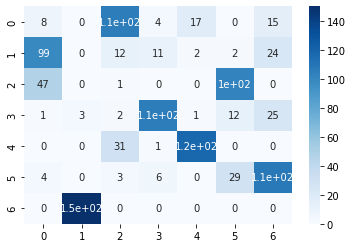

In [62]:
sns.heatmap(conf_mat, annot=True, cmap="Blues")

In [63]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    #corresp = [6,4,2,1,5,0,3]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(data["_main_category_num"], cls.labels_)
conf_mat = metrics.confusion_matrix(data["_main_category_num"], cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(data["_main_category_num"], cls_labels_transform))

Correspondance des clusters :  [1 6 0 3 4 2 5]
[[106   8   0   4  17  15   0]
 [ 12  99   2  11   2  24   0]
 [  1  47 102   0   0   0   0]
 [  2   1  12 106   1  25   3]
 [ 31   0   0   1 118   0   0]
 [  3   4  29   6   0 108   0]
 [  0   0   0   0   0   0 150]]

              precision    recall  f1-score   support

           0       0.68      0.71      0.70       150
           1       0.62      0.66      0.64       150
           2       0.70      0.68      0.69       150
           3       0.83      0.71      0.76       150
           4       0.86      0.79      0.82       150
           5       0.63      0.72      0.67       150
           6       0.98      1.00      0.99       150

    accuracy                           0.75      1050
   macro avg       0.76      0.75      0.75      1050
weighted avg       0.76      0.75      0.75      1050



<AxesSubplot:>

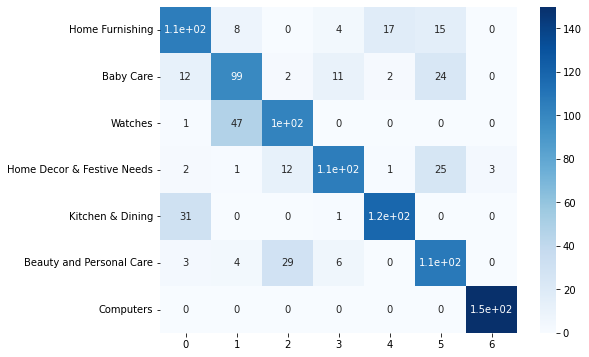

In [64]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in main_categ_list],
                  columns = [i for i in range(7)])
plt.figure(figsize = (8,6))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [65]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
y_cat_num=data['_main_category_num'].values
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(main_categ_list)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=main_categ_list, loc="best", title="Categorie")
    plt.title('Représentation produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)


### 1.4 Approche Word / Sentence Embedding <a class="anchor" id="section_1_4"></a>
The bag-of-words approach results in a document-term matrix that is, for the most part, filled with zeros called a sparse matrix. Most words are only present in a small set of documents. It is a waste of precious space. 
==> a dense vector representation of tokens where the document-term matrix is no longer sparse.

Les incorporations de mots nous permettent d'utiliser une représentation efficace et dense dans laquelle des mots similaires ont un encodage similaire. Une incorporation est un vecteur dense de valeurs à virgule flottante. Au lieu de spécifier manuellement les valeurs pour l'intégration, ce sont des paramètres entraînables (poids appris par le modèle lors de l'entraînement, de la même manière qu'un modèle apprend des poids pour une couche dense). 

#### 1.4.1 Approche classique Word2Vec <a class="anchor" id="section_1_4_1"></a>

Word2Vec is a more recent model that embeds words (plongement de mot) in a lower-dimensional vector space using a shallow neural  network (1 couche cachée). The result is a set of word-vectors where vectors close together in vector space have similar meanings based on context, and word-vectors distant to each other have differing meanings.
The are two versions of this model and Word2Vec class implements them both:

* Skip-grams (SG) : un token et autant de couple de token autour

* Continuous-bag-of-words (CBOW) : à partir d'un contexte, prédire le token du milieu

==> Représentation Word2Vec : vecteur de réels dense (pas creux) et mots proches ont représentation vectorielle proche.
On entraine un réseau de neuronne simple à prédire les sorties à partir des entrées.
Une couche entrée, une intermediaire et une sortie.
La couche d'entrée et la couche de sortie ont la même taille = taille du vocabulaire.
chaque neurone est un token.
Ordre de grandeur 300 neuronnes pour la couche intermédiaire.
les poids de la couche intermédiaire donnent un vecteur qui représente le mot.
Les vecteurs  capturent proximité entre les termes : des mots avec concepts similiraire se retouvent ds contexte similaires.

documentation : https://radimrehurek.com/gensim/models/word2vec.html

#### Création du modèle

In [66]:
# Création du modèle
sentences = data['_name_desc_bow'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences] # Liste de liste (Découpage des descriptions en liste de mots)

In [67]:
sentences

[['elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'key',
  'feature',
  'elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'floral',
  'curtain',
  'elegance',
  'polyester',
  'multicolor',
  'abstract',
  'eyelet',
  'door',
  'curtain',
  'height',
  'pack',
  'price',
  'curtain',
  'enhances',
  'look',
  'interiors',
  'this',
  'curtain',
  'made',
  'high',
  'quality',
  'polyester',
  'fabric',
  'it',
  'feature',
  'eyelet',
  'style',
  'stitch',
  'metal',
  'ring',
  'it',
  'make',
  'room',
  'environment',
  'romantic',
  'loving',
  'this',
  'curtain',
  'ant',
  'wrinkle',
  'anti',
  'shrinkage',
  'elegant',
  'apparance',
  'give',
  'home',
  'bright',
  'modernistic',
  'appeal',
  'design',
  'surreal',
  'attention',
  'sure',
  'steal',
  'heart',
  'contemporary',
  'eyelet',
  'valance',
  'curtain',
  'slide',
  'smoothly',
  'draw',
  'apart',
  'first',
  'thing',


In [68]:
w2v_size=300 #  Dimensionality of the word vectors.
w2v_window=5 # Maximum distance between the current and predicted word within a sentence.
w2v_min_count=1 # Ignores all words with total frequency lower than this.
w2v_epochs=100 #  Number of iterations (epochs) over the corpus. (Formerly: iter)
maxlen = 100 # adapt to length of sentences

# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42, # Seed for the random number generator
                                                workers=1) # Use these many worker threads to train the model (=faster training with multicore machines).
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4647
Word2Vec trained


In [69]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4648


#### Création de la matrice d'embedding

In [70]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4648, 300)


#### Création du modèle d'embedding

In [71]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          1394400   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,394,400
Trainable params: 1,394,400
Non-trainable params: 0
_________________________________________________________________


#### Exécution du modèle

In [72]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 1ms/step


(1050, 300)

In [73]:
embeddings

array([[-0.21932644, -0.08765916,  0.27384272, ..., -0.31996813,
        -0.00579488, -0.09768102],
       [-0.54259986,  0.08193909,  0.41455212, ..., -0.30395994,
         0.2986451 , -0.39641988],
       [-0.40676332,  0.14581265,  0.48228922, ..., -0.4155851 ,
         0.42121667, -0.6096214 ],
       ...,
       [ 0.04210036,  0.11829166,  0.0369563 , ..., -0.29443204,
        -0.22759442,  0.05812076],
       [ 0.1337095 ,  0.13069516, -0.01554561, ..., -0.43531168,
        -0.24938124,  0.07009005],
       [ 0.03379425,  0.16422386, -0.00705798, ..., -0.33327156,
        -0.18043335,  0.04498036]], dtype=float32)

In [74]:
# Calcul Tsne
num_labels=len(main_categ_list)
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(embeddings)
 
# création d'un df avec les données du tsne 
df_tsne_W2V = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_W2V["category"] = data["_main_category"] # ajout de la colonne correspondant à la vraie catégorie de chaque produit
df_tsne_W2V    
    
# Détermination des clusters à partir des données issues du t-SNE 
cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
cls.fit(X_tsne)
df_tsne_W2V['cluster'] = cls.labels_ # ajout au df des label du clustering


C:\Users\Léa Zadikian\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


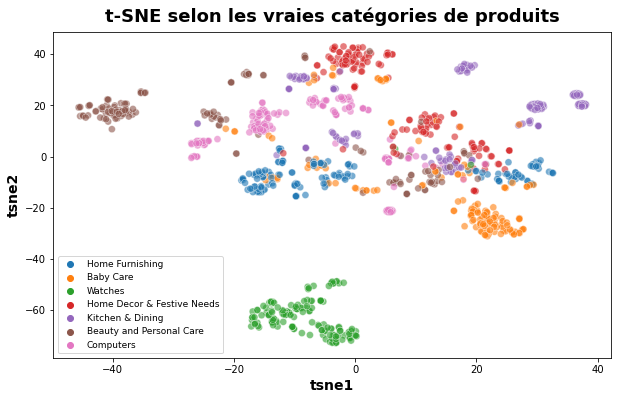

In [75]:
# Visualisation du t-SNE selon les vraies catégories

plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="category", data=df_tsne_W2V, legend='brief',
    palette=sns.color_palette('tab10', n_colors=len(main_categ_list)), 
    s=50, alpha=0.6
    )

plt.title('t-SNE selon les vraies catégories de produits', fontsize = 18, pad = 10, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
plt.legend(prop={'size': 9},loc='best') 

plt.show()

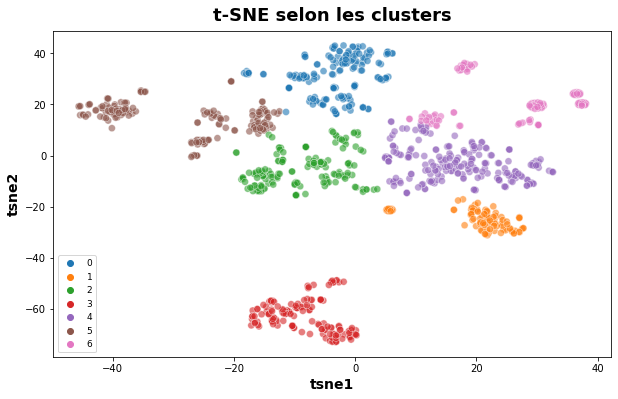

In [76]:
# Affichage des produits selon les clusters
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",hue='cluster',
    palette=sns.color_palette('tab10', n_colors=len(main_categ_list)), 
    s=50, alpha=0.6,
    data=df_tsne_W2V,
    legend="brief")

plt.title('t-SNE selon les clusters', fontsize = 18, pad = 10, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
plt.legend(prop={'size': 9}) 

plt.show()


In [77]:
# Score ARI
ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
print("Score ARI approche word2Vec : ", ARI)
    

Score ARI approche word2Vec :  0.3759


#### 1.4.2 Word Embedding avec BERT <a class="anchor" id="section_1_4_2"></a>
BERT (Bidirectional Encoder Representations from Transformers) provides dense vector representations for natural language by using a deep, pre-trained neural network with the Transformer architecture. It was originally published by Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova: "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", 2018.
This TF Hub model uses the implementation of BERT from the TensorFlow Models repository on GitHub at tensorflow/models/official/legacy/bert. It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads.

The weights of this model are those released by the original BERT authors. This model has been pre-trained for English on the Wikipedia and BooksCorpus. Text inputs have been normalized the "uncased" way, meaning that the text has been lower-cased before tokenization into word pieces, and any accent markers have been stripped. For training, random input masking has been applied independently to word pieces (as in the original BERT paper).

All parameters in the module are trainable, and fine-tuning all parameters is the recommended practice.

In [78]:
os.environ["TF_KERAS"]='1'
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.1
2.10.1
Num GPUs Available:  0
True


In [79]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [80]:
# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [81]:
sentences = data['_name_desc_dl'].to_list()

#### Modèle 'bert-base-uncased'

In [82]:
max_length = 100
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  84.0


In [83]:
features_bert.shape

(1050, 768)

In [84]:
# Calcul Tsne
num_labels=len(main_categ_list)
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(features_bert)
 
# création d'un df avec les données du tsne 
df_tsne_bert = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_bert["category"] = data["_main_category"] # ajout de la colonne correspondant à la vraie catégorie de chaque produit
    
# Détermination des clusters à partir des données issues du t-SNE 
cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
cls.fit(X_tsne)
df_tsne_bert['cluster'] = cls.labels_ # ajout au df des label du clustering


C:\Users\Léa Zadikian\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


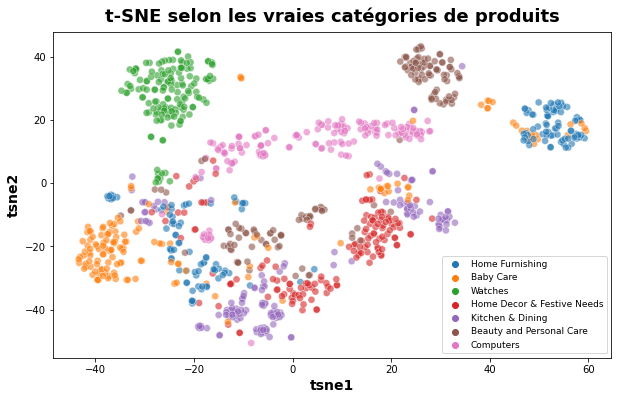

In [85]:
# Visualisation du t-SNE selon les vraies catégories

plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="category", data=df_tsne_bert, legend='brief',
    palette=sns.color_palette('tab10', n_colors=len(main_categ_list)), 
    s=50, alpha=0.6
    )

plt.title('t-SNE selon les vraies catégories de produits', fontsize = 18, pad = 10, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
plt.legend(prop={'size': 9},loc='best') 

plt.show()

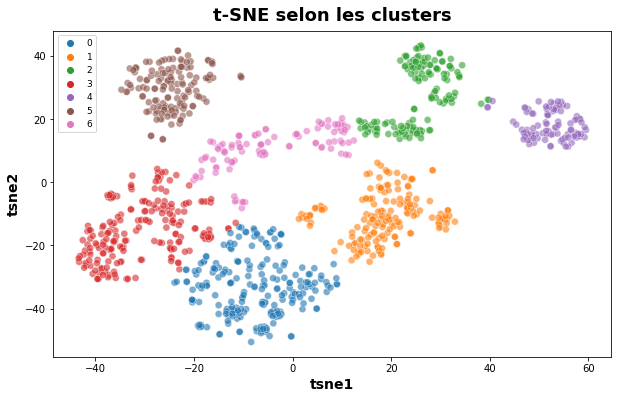

In [86]:
# Affichage des produits selon les clusters
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",hue='cluster',
    palette=sns.color_palette('tab10', n_colors=len(main_categ_list)), 
    s=50, alpha=0.6,
    data=df_tsne_bert,
    legend="brief")

plt.title('t-SNE selon les clusters', fontsize = 18, pad = 10, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
plt.legend(prop={'size': 9}) 

plt.show()


In [87]:
# Score ARI
ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
print("Score ARI approche BERT : ", ARI)

Score ARI approche BERT :  0.3588


#### 1.4.3 Sentence Embedding avec USE <a class="anchor" id="section_1_4_3"></a>
* Encoder of greater-than-word length text trained on a variety of data.
* The Universal Sentence Encoder encodes text into high-dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

* The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks.

    * Input : variable length English text 
    * Output : a 512 dimensional vector. 
* The USE model is trained with a deep averaging network (DAN) encoder.

* This encoder differs from word level embedding models in that we train on a number of natural language prediction tasks that require modeling the meaning of word sequences rather than just individual words. 
Details in the paper "Universal Sentence Encoder" : https://arxiv.org/pdf/1803.11175.pdf

* The module does not require preprocessing the data before applying the module, it performs best effort text input preprocessing inside the graph.

In [88]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.1
2.10.1
Num GPUs Available:  0
True


In [89]:
# Fonction  pour calculer USE
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    return features

We don't use standard preprocessing steps like stemming or stopword removal when you have pre-trained embeddings (such as removing stopwords, stemming)
We loose valuable information, which would help your NN to figure things out.

In [90]:
# Calcul des données USE
batch_size = 10
sentences = data['_name_desc_bow'].to_list()
features_USE = feature_USE_fct(sentences, batch_size)

In [91]:
features_USE.shape

(1050, 512)

In [92]:
# Calcul Tsne
num_labels=len(main_categ_list)
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(features_USE)
 
# création d'un df avec les données du tsne 
df_tsne_use = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_use["category"] = data["_main_category"] # ajout de la colonne correspondant à la vraie catégorie de chaque produit
    
# Détermination des clusters à partir des données issues du t-SNE 
cls_use = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
cls_use.fit(X_tsne)
df_tsne_use['cluster'] = cls_use.labels_ # ajout au df des label du clustering


C:\Users\Léa Zadikian\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


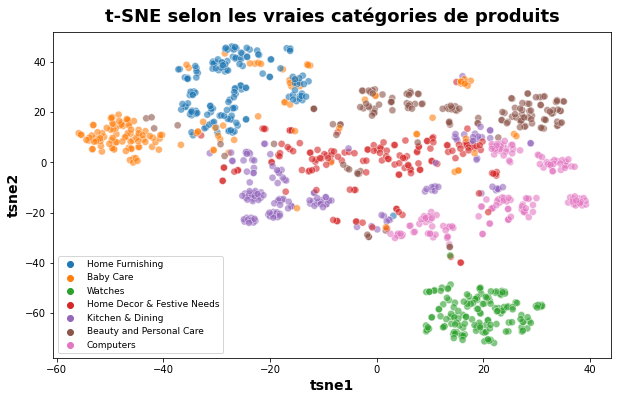

In [93]:
# Visualisation du t-SNE selon les vraies catégories

plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="category", data=df_tsne_use, legend='brief',
    palette=sns.color_palette('tab10', n_colors=len(main_categ_list)), 
    s=50, alpha=0.6
    )

plt.title('t-SNE selon les vraies catégories de produits', fontsize = 18, pad = 10, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
plt.legend(prop={'size': 9},loc='best') 

plt.show()

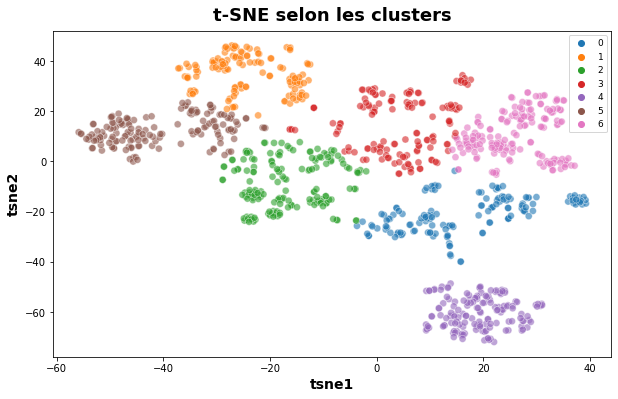

In [94]:
# Affichage des produits selon les clusters
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",hue='cluster',
    palette=sns.color_palette('tab10', n_colors=len(main_categ_list)), 
    s=50, alpha=0.6,
    data=df_tsne_use,
    legend="brief")

plt.title('t-SNE selon les clusters', fontsize = 18, pad = 10, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
plt.legend(prop={'size': 9}) 

plt.show()


In [95]:
# Score ARI
ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls_use.labels_),4)
print("Score ARI approche USE : ", ARI)

Score ARI approche USE :  0.4613


Commentaires issus du notebook d'exemple de faisabilité fourni dans les ressources du projet.
* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les produits selon leurs vraies catégories
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité évite de réaliser des traitements beaucoup plus lourd de classification supervisée.
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data.
* Une mesure de l'ARI permet de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne.
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement

## Partie 2 :  Traitement des données visuelles <a class="anchor" id="partie2"></a>

### 2.1 Pré-traitement des données visuelles <a class="anchor" id="section_2_1"></a>

In [96]:
path = 'C:\\Users\\Public\\OPENCLASSROOMS\\PROJET 6\\Flipkart\\Images\\'
list_photos = os.listdir(path)
list_photos

['009099b1f6e1e8f893ec29a7023153c4.jpg',
 '0096e89cc25a8b96fb9808716406fe94.jpg',
 '00cbbc837d340fa163d11e169fbdb952.jpg',
 '00d84a518e0550612fcfcba3b02b6255.jpg',
 '00e966a5049a262cfc72e6bbf68b80e7.jpg',
 '00ed03657cedbe4663eff2d7fa702a33.jpg',
 '01089dc3618a0ab7304d784ef400b83d.jpg',
 '0131e5d87b72877702d536299cf83b75.jpg',
 '020d2daba55a723128e4e07c0b0393a9.jpg',
 '02127f52e96fb72c66bf081d25104ef8.jpg',
 '025a85a3d1cddc6307f7dc075d8d2132.jpg',
 '02a53d335775b652f22f41b529b9d646.jpg',
 '02c63a087b298ec74042d557acf61be1.jpg',
 '031c98cfde349d99fb6d5983f54c8751.jpg',
 '032e812adcd11a38fd8b764891a852ff.jpg',
 '037b39bef3db7ccd264c577a0edf0c0a.jpg',
 '037c2402fee39fbc80433935711d1383.jpg',
 '04f9f818e2d657b873b07578cfe2eade.jpg',
 '04f9ff160a1561e3656350f4bd6b8c50.jpg',
 '050ea3acb555bf641e7ae9b4f3ba684a.jpg',
 '052559ede419996737893eb47568ee7f.jpg',
 '057836ecde71565f8ebdd576e41fdc96.jpg',
 '059493eeb88ebb4cc08d1522f3f87c3f.jpg',
 '059bc43e03e1824a9ab6466e32e5f137.jpg',
 '06749cbff1487f

In [97]:
print("Nombre de photos dans le repertoire : "+str(len(list_photos)))

Nombre de photos dans le repertoire : 1050


#### Affichage d'une image

In [98]:
# Création du nom du fichier image à partir du chemin d'accès et du nom de l'image
filename_test=path+list_photos[random.randint(1,1050)] # un nom d'image au hasard
filename_test

'C:\\Users\\Public\\OPENCLASSROOMS\\PROJET 6\\Flipkart\\Images\\d43d9bb261aaaf818c81a645e727b2d3.jpg'

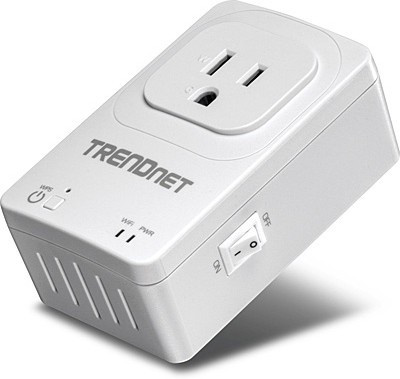

In [99]:
# Affichage de l'image
image_test =Image.open(filename_test)
image_test

#### Affichage d'exemples d'images par catégorie

In [100]:
# Fonction permettant de récupérer la liste des images d'une catégorie donnée, en passant en argument de la focntion le nom de la catégorie.
def list_fct(category) :
    list_image =data.loc[data['_main_category']==category,'image'].values
    return list_image

Home Furnishing


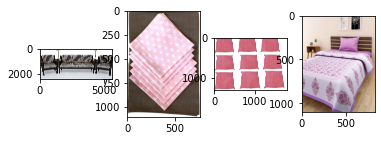

Baby Care


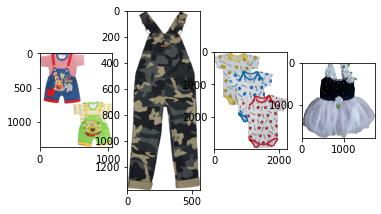

Watches


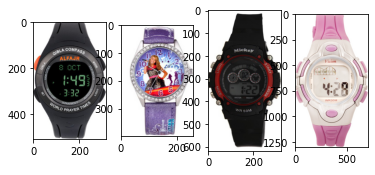

Home Decor & Festive Needs


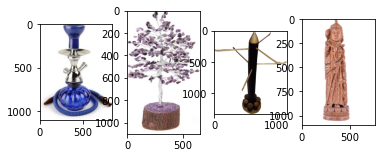

Kitchen & Dining


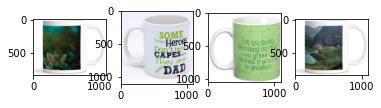

Beauty and Personal Care


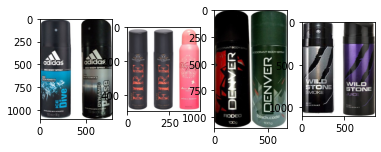

Computers


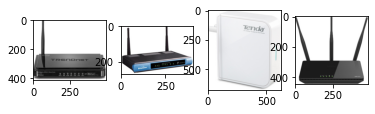

In [101]:
# Boucle sur l'ensemble des catégories de produits pour afficher 4 produits de chaque catégorie
for category in main_categ_list :
    print(category)
    
    for i in range(4):
        plt.subplot(141 + i)
        filename = path + list_fct(category)[i+20]
        image = Image.open(filename)
        plt.imshow(image)
    plt.show()

#### Pré-traitement sur une image : Détermination et affichage des descripteurs SIFT

* Chaque descripteur est un vecteur de longueur 128
Ressources : https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html

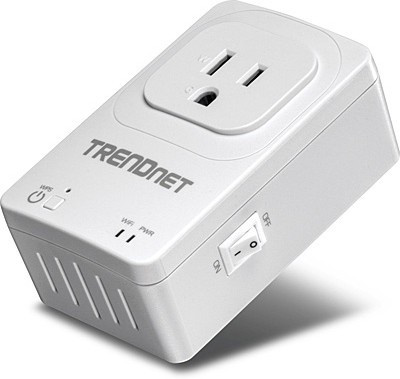

In [102]:
image_test

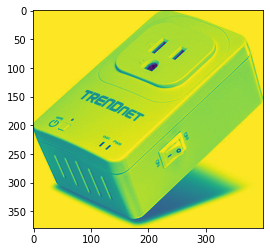

In [103]:
# Lecture de l'image par openCV et passage en niveaux de gris
image_test = cv2.imread(filename_test,0) # convert in gray // cv2.IMREAD_GRAYSCALE: It specifies to load an image in grayscale mode. Alternatively, we can pass integer value 0 for this flag.
plt.imshow(image_test)

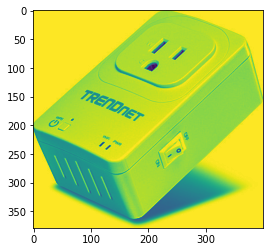

In [104]:
# Autre façon pour la Lecture de l'image par openCV et passage en niveaux de gris
image_test = cv2.imread(filename_test)
gray= cv2.cvtColor(image_test,cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

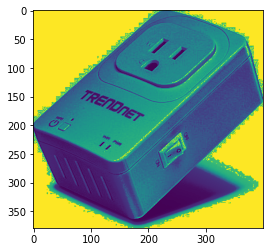

In [105]:
# Histograme de l'image égalisée
image_test = cv2.equalizeHist(gray)   # equalize image histogram ( input : grayscale image / output : histogram equalized image.)
plt.imshow(image_test)

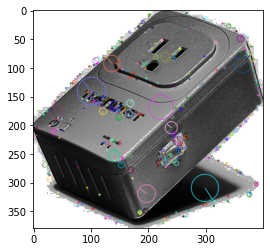

Descripteurs :  (359, 128)

[[66.  6.  0. ...  0.  0.  0.]
 [ 2.  2.  0. ...  0.  0.  9.]
 [ 6.  0.  0. ... 31.  3.  0.]
 ...
 [12.  4.  1. ...  0.  1. 31.]
 [ 5.  6.  2. ... 15.  0.  1.]
 [56.  5.  0. ...  0.  0.  7.]]


In [106]:
# Détermination et affiche des descripteurs SIFT
sift = cv2.SIFT_create()
image_test = cv2.imread(filename_test,0) # convert in gray // cv2.IMREAD_GRAYSCALE: It specifies to load an image in grayscale mode. Alternatively, we can pass integer value 0 for this flag.
image_test = cv2.equalizeHist(image_test)   # equalize image histogram (Its input is just grayscale image and output is histogram equalized image.)
kp, descript =sift.detectAndCompute(image_test, None) #  finds the keypoint in the images. 

# Draws the small circles on the locations of keypoints
# flag cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS : draws a circle with size of keypoint and shows its orientation
img=cv2.drawKeypoints(image_test,kp,image_test,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(img)
plt.show()
print("Descripteurs : ", descript.shape)
print()
print(descript)


### 2.2 Approche SIFT <a class="anchor" id="section_2_2"></a>

### Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* Création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* Création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisée pour créer les clusters de descripteurs

In [107]:
# Identification of key points and associated descriptors

sift_keypoints = []
temps1=time.time()
sift = cv2.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num) # Print toutes toutes les 100 images (n° multiple de 100)
    gray = cv2.imread(path+list_photos[image_num],0) # convert in gray
    hist = cv2.equalizeHist(gray)   # equalize image histogram
    kp, des = sift.detectAndCompute(hist, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("Temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000


C:\Users\Léa Zadikian\AppData\Local\Temp\ipykernel_17244\1699105521.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)



Nombre de descripteurs :  (517351, 128)
Temps de traitement SIFT descriptor :           325.97 secondes


### Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables. Moins long que le K means, avec résultats qui restent pertinents
* 2 approches pour le nombre de clusters :
    * Racine carrée du nombre total de descripteurs ( vue comme le nombre maxi de clusters)
    * Nombre de catégories à traiter * 10 : une autre approche vue comme le nombre mini de clusters

In [108]:
# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0)) # nb de clusters k = racine carrée du nb total de descripteurs, recommandation(ou nb maxi de clusters)
#k =10*len(main_category_list) # Autre approche avevc k= nb de catégories à traiter *10, vue comme le nb minimal de clusters
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...


C:\Users\Léa Zadikian\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1848: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


temps de traitement kmeans :             9.81 secondes


### Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image
    
* Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [109]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("Temps de création des histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
Temps de création des histogrammes :            65.62 secondes


In [110]:
im_features.shape

(1050, 719)

In [111]:
im_features

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.002     , 0.        ,
        0.008     ],
       [0.        , 0.        , 0.        , ..., 0.00199601, 0.00199601,
        0.00199601],
       ...,
       [0.        , 0.002     , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.018     ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00598802]])

### Réduction de dimensions
#### Réduction de dimension ACP
* La réduction ACP permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [112]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
X_img_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", X_img_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 498)


#### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [113]:
df_tsne['image_name_jpg']=list_photos
df_tsne

tsne1      tsne2         category  cluster  \
0      0.954382  31.039406  Home Furnishing        4   
1     -6.697587  51.033314        Baby Care        2   
2    -10.195909  52.238831        Baby Care        2   
3      8.093552  39.596966  Home Furnishing        4   
4      7.714569  39.323425  Home Furnishing        4   
...         ...        ...              ...      ...   
1045  -5.055168 -15.929614        Baby Care        6   
1046  -3.122236 -16.009962        Baby Care        6   
1047  -0.076101 -14.104072        Baby Care        6   
1048  -0.784227 -16.558861        Baby Care        6   
1049  -0.216026 -14.780348        Baby Care        6   

                            image_name_jpg  
0     009099b1f6e1e8f893ec29a7023153c4.jpg  
1     0096e89cc25a8b96fb9808716406fe94.jpg  
2     00cbbc837d340fa163d11e169fbdb952.jpg  
3     00d84a518e0550612fcfcba3b02b6255.jpg  
4     00e966a5049a262cfc72e6bbf68b80e7.jpg  
...                                    ...  
1045  feefbdff924dd6b7cc266449c9a36d69.jpg  
1046  ff24511994fc459d04145231c8876d6c.jpg  
1047  ffbf3794aa8cb6bb8d3f313d0a549a09.jpg  
1048  ffc2e1fc7c886ec09a331040ada038aa.jpg  
1049  fffa2117a4006d4a848eb7d5b80d4816.jpg  

[1050 rows x 5 columns]

In [114]:
# Calcul du tsne
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     learning_rate=200,
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(X_img_pca)

# création d'un df avec les données du tsne et récupération des vraies catégories textuelles et numériques
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne['image_name_jpg']=list_photos
df_tsne=pd.merge(df_tsne,data.loc[:,['image','_main_category','_main_category_num']],left_on='image_name_jpg',right_on='image',how='left')
df_tsne

tsne1      tsne2                        image_name_jpg  \
0    -10.559707  40.827702  009099b1f6e1e8f893ec29a7023153c4.jpg   
1    -22.781454 -21.264288  0096e89cc25a8b96fb9808716406fe94.jpg   
2     34.420902 -13.926204  00cbbc837d340fa163d11e169fbdb952.jpg   
3     -6.573960   4.942605  00d84a518e0550612fcfcba3b02b6255.jpg   
4    -24.406431  26.475187  00e966a5049a262cfc72e6bbf68b80e7.jpg   
...         ...        ...                                   ...   
1045  -3.669943  16.597960  feefbdff924dd6b7cc266449c9a36d69.jpg   
1046  -5.333352   7.104328  ff24511994fc459d04145231c8876d6c.jpg   
1047  19.043798  15.619629  ffbf3794aa8cb6bb8d3f313d0a549a09.jpg   
1048   6.148018  -8.937196  ffc2e1fc7c886ec09a331040ada038aa.jpg   
1049  -3.411330   5.012825  fffa2117a4006d4a848eb7d5b80d4816.jpg   

                                     image            _main_category  \
0     009099b1f6e1e8f893ec29a7023153c4.jpg                   Watches   
1     0096e89cc25a8b96fb9808716406fe94.jpg          Kitchen & Dining   
2     00cbbc837d340fa163d11e169fbdb952.jpg           Home Furnishing   
3     00d84a518e0550612fcfcba3b02b6255.jpg  Beauty and Personal Care   
4     00e966a5049a262cfc72e6bbf68b80e7.jpg                 Computers   
...                                    ...                       ...   
1045  feefbdff924dd6b7cc266449c9a36d69.jpg          Kitchen & Dining   
1046  ff24511994fc459d04145231c8876d6c.jpg           Home Furnishing   
1047  ffbf3794aa8cb6bb8d3f313d0a549a09.jpg          Kitchen & Dining   
1048  ffc2e1fc7c886ec09a331040ada038aa.jpg           Home Furnishing   
1049  fffa2117a4006d4a848eb7d5b80d4816.jpg                 Computers   

      _main_category_num  
0                      6  
1                      5  
2                      4  
3                      1  
4                      2  
...                  ...  
1045                   5  
1046                   4  
1047                   5  
1048                   4  
1049                   2  

[1050 rows x 6 columns]

### Analyse visuelle : affichage T-SNE selon catégories d'images


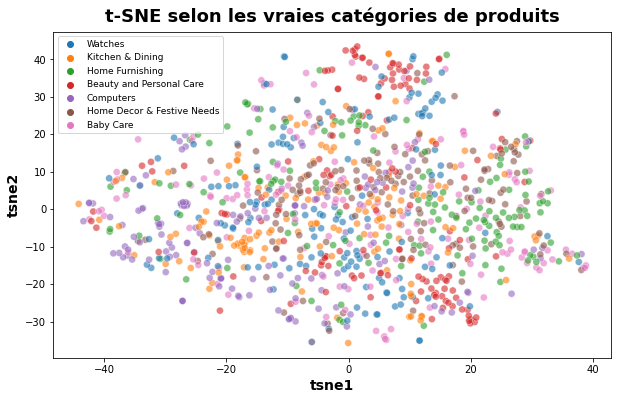

In [115]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="_main_category", data=df_tsne, legend='brief',
    palette=sns.color_palette('tab10', n_colors=len(main_categ_list)), 
    s=50, alpha=0.6
    )

plt.title('t-SNE selon les vraies catégories de produits', fontsize = 18, pad = 10, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
plt.legend(prop={'size': 9},loc='best') 

plt.show()

###  Création de clusters à partir du T-SNE

In [116]:
 # Détermination des clusters à partir des données t-SNE 
cls = KMeans(n_clusters=len(main_categ_list),n_init=100, random_state=42)
cls.fit(X_tsne)
df_tsne['cluster'] = cls.labels_

C:\Users\Léa Zadikian\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

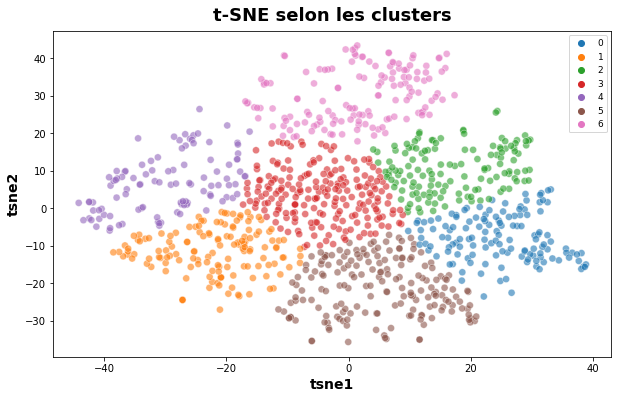

In [117]:
# Affichage des produits selon les clusters
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",hue='cluster',
    palette=sns.color_palette('tab10', n_colors=len(main_categ_list)), 
    s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('t-SNE selon les clusters', fontsize = 18, pad = 10, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
plt.legend(prop={'size': 9}) 

plt.show()


In [118]:
# Calcul du score ARI
ARI =  np.round(metrics.adjusted_rand_score(df_tsne["_main_category_num"].values, cls.labels_),4)
print("Score ARI : ",ARI)

Score ARI :  0.0557


Avec l'approche k=(10*le nombre de catégories à traiter), soit k=70 pour ce projet, pour l'étape du clustering des descripteurs, le score ARI serait de 0.0459, versus 0.5507 avec l'approche k = racine carrée du nb de descripteurs (soit k=719). 
La conclusion reste la même, l'algo SIFT ne permet pas une bonne séparation des catégories.

### 2.3 Approche CNN Transfert Learning avec VGG-16 <a class="anchor" id="section_2_3"></a>
source : cours Openclassrooms " Classez et segmentez vos données visuelles"

**Les CNN**
* Les réseaux de neurones convolutifs ( CNN ou ConvNet pour Convolutional Neural Network), sont toujours les modèles les plus performants pour la classification d'images. Les réseaux de neurones convolutifs ont une méthodologie similaire à celle des méthodes traditionnelles d'apprentissage supervisé : ils reçoivent des images en entrée, détectent les features de chacune d'entre elles, puis entraînent un classifieur dessus. Cependant, les features sont apprises automatiquement. Les CNN réalisent eux-mêmes le travail d'extraction et description de features : lors de la phase d'entraînement, l'erreur de classification est minimisée afin d'optimiser les paramètres du classifieur et les features. Contrairement aux techniques d'apprentissage supervisé, les réseaux de neurones convolutifs apprennent les features de chaque image. C'est là que réside leur force : les réseaux réalisent l'extraction de features automatiquement, contrairement aux techniques d'apprentissage  

* Pour les problème de classification, le réseau calcule à partir de l'entrée un score (ou probabilité) pour chaque classe. La classe attribuée à l'objet en entrée correspond à celle de score le plus élevé 


* Les réseaux de neurones convolutifs désignent une sous-catégorie de réseaux de neurones. Cependant, les CNN sont spécialement conçus pour traiter des images en entrée. Leur architecture est alors plus spécifique : elle est composée de deux blocs principaux.
    * Le premier bloc fait la particularité de ce type de réseaux de neurones, puisqu'il fonctionne comme un extracteur de features. Pour cela, il effectue du template matching en appliquant des opérations de filtrage par convolution. La première couche filtre l'image avec plusieurs noyaux de convolution, et renvoie des "feature maps", qui sont ensuite normalisées (avec une fonction d'activation) et/ou redimensionnées. Ce procédé peut être réitéré plusieurs fois : on filtre les features maps obtenues avec de nouveaux noyaux, ce qui nous donne de nouvelles features maps à normaliser et redimensionner, et qu'on peut filtrer à nouveau, et ainsi de suite. Finalement, les valeurs des dernières feature maps sont concaténées dans un vecteur. Ce vecteur définit la sortie du premier bloc, et l'entrée du second.
    * Le second bloc n'est pas caractéristique d'un CNN : il se retrouve en fait à la fin de tous les réseaux de neurones utilisés pour la classification. Les valeurs du vecteur en entrée sont transformées (avec plusieurs combinaisons linéaires et fonctions d'activation) pour renvoyer un nouveau vecteur en sortie. Ce dernier vecteur contient autant d'éléments qu'il y a de classes : l'élément i représente la probabilité que l'image appartienne à la classe i. Chaque élément est donc compris entre 0 et 1, et la somme de tous vaut 1. Ces probabilités sont calculées par la dernière couche de ce bloc (et donc du réseau), qui utilise une fonction logistique (classification binaire) ou une fonction softmax (classification multi-classe) comme fonction d'activation.

* Comme pour les réseaux de neurones ordinaires, les paramètres des couches sont déterminés par rétropropagation du gradient : l'entropie croisée est minimisée lors de la phase d'entraînement. Mais dans le cas des CNN, ces paramètres désignent en particulier les features des images.

**VGG-16**
* VGG-16 (Visual Geometry Group, de l'Université d'Oxford), une version du réseau de neurones convolutif très connu appelé VGG-Net.Le modèle VGG16 est composé de 16 couches (13 couches de convolution et 3 couches entièrement connectées) et est entraîné sur l'ensemble de données ImageNet, qui comprend plus d'un million d'images réparties en 1000 classes.

**Le Transfer learning**

* Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify tanukis.Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.
* The most common incarnation of transfer learning in the context of deep learning is the following workflow:
    * Take layers from a previously trained model.
    * Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
    * Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
    * Train the new layers on your dataset.

### Création du modèle pré-entraîné VGG-16

In [119]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Création des features des images - test sur une 1 image

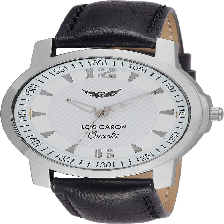

In [120]:
#  loads an image and re-size it to 224 x 224 pixels.
img = load_img(path+data['image'][12], target_size=(224, 224))  # image avec index 112 (au hasard)
img

In [121]:
#converts an image to a 3DD numpy array for (height, width, channel).
#For RGB images, the value for “channel” is 3. For grayscale images, the value is 1.
img = img_to_array(img)  # Convertir en tableau numpy
img.shape

(224, 224, 3)

In [122]:
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img.shape


(1, 224, 224, 3)

In [123]:
# VGG-16 expects the 3-D input format to be 4-D (batch, height, width, channel)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16
img.shape

(1, 224, 224, 3)

On passe de 3D à 4D : (batch, height, width, channel).
The batch size is 1 because each batch has one image.

### Création des features images (sur l'ensemble du dataset) avec VGG-16

In [124]:
# Création des features images sur l'ensemble des images

temps_CNN_TL=time.time()

images_features = []
i=0 
for image_num in range(len(list_photos)) :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(path+list_photos[image_num], target_size=(224, 224)) # chargement de l'image
    image = img_to_array(image)  # conversion en tableau numpy
    image = np.expand_dims(image, axis=0)  # Créer la collection d'images (un seul échantillon)
    #image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))  # Créer la collection d'images (un seul échantillon)
    image = preprocess_input(image) # Prétraitement l'image comme le veut VGG-16
    images_features.append(model.predict(image, verbose=0)[0]) # predict class from pretrained model ImageNet

    duration_CNN_TL=time.time()-temps_CNN_TL
print("Temps de création des features images avec VGG-16 : ", "%15.2f" % duration1, "secondes")

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300


C:\Anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


400
500
600
700
800
900
1000
Temps de création des features images avec VGG-16 :            65.62 secondes


(1050, 4096)

### Réduction de dimension PCA

In [125]:
print("Dimensions dataset avant réduction PCA : ", images_features.shape)
pca = decomposition.PCA(n_components=0.99) # Conservation de 99% de la variance expliquée
X_VGG16_pca= pca.fit_transform(images_features)
print("Dimensions dataset après réduction PCA : ", X_VGG16_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 803)


### Réduction de dimension T-SNE et affichage des images selon vraies catégories

In [126]:
df_tsne_VGG16=[]

# Calcul du tsne
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     learning_rate=200,
                     n_iter=2000, init='random', random_state=42)
X_tsne_VGG16 = tsne.fit_transform(X_VGG16_pca)

# création d'un df avec les données du tsne et récupération des vraies catégories textuelles et numériques
df_tsne_VGG16 = pd.DataFrame(X_tsne_VGG16[:,0:2], columns=['tsne1', 'tsne2']) # données du tnse
df_tsne_VGG16['image_name_jpg']=list_photos # ajout d'une colonne avec nom.jpeg de la photo
df_tsne_VGG16=pd.merge(df_tsne_VGG16,data.loc[:,['image','_main_category','_main_category_num']],left_on='image_name_jpg',right_on='image',how='left')
df_tsne_VGG16

tsne1      tsne2                        image_name_jpg  \
0      6.509724  26.712286  009099b1f6e1e8f893ec29a7023153c4.jpg   
1     -2.278659   8.413411  0096e89cc25a8b96fb9808716406fe94.jpg   
2      6.566978 -17.477728  00cbbc837d340fa163d11e169fbdb952.jpg   
3    -20.298014 -21.490110  00d84a518e0550612fcfcba3b02b6255.jpg   
4     -2.018606  -4.440088  00e966a5049a262cfc72e6bbf68b80e7.jpg   
...         ...        ...                                   ...   
1045 -41.920219  -4.992565  feefbdff924dd6b7cc266449c9a36d69.jpg   
1046  41.603149 -14.481892  ff24511994fc459d04145231c8876d6c.jpg   
1047 -49.793613   2.970113  ffbf3794aa8cb6bb8d3f313d0a549a09.jpg   
1048  37.718952  -8.566457  ffc2e1fc7c886ec09a331040ada038aa.jpg   
1049   2.325122   9.312838  fffa2117a4006d4a848eb7d5b80d4816.jpg   

                                     image            _main_category  \
0     009099b1f6e1e8f893ec29a7023153c4.jpg                   Watches   
1     0096e89cc25a8b96fb9808716406fe94.jpg          Kitchen & Dining   
2     00cbbc837d340fa163d11e169fbdb952.jpg           Home Furnishing   
3     00d84a518e0550612fcfcba3b02b6255.jpg  Beauty and Personal Care   
4     00e966a5049a262cfc72e6bbf68b80e7.jpg                 Computers   
...                                    ...                       ...   
1045  feefbdff924dd6b7cc266449c9a36d69.jpg          Kitchen & Dining   
1046  ff24511994fc459d04145231c8876d6c.jpg           Home Furnishing   
1047  ffbf3794aa8cb6bb8d3f313d0a549a09.jpg          Kitchen & Dining   
1048  ffc2e1fc7c886ec09a331040ada038aa.jpg           Home Furnishing   
1049  fffa2117a4006d4a848eb7d5b80d4816.jpg                 Computers   

      _main_category_num  
0                      6  
1                      5  
2                      4  
3                      1  
4                      2  
...                  ...  
1045                   5  
1046                   4  
1047                   5  
1048                   4  
1049                   2  

[1050 rows x 6 columns]

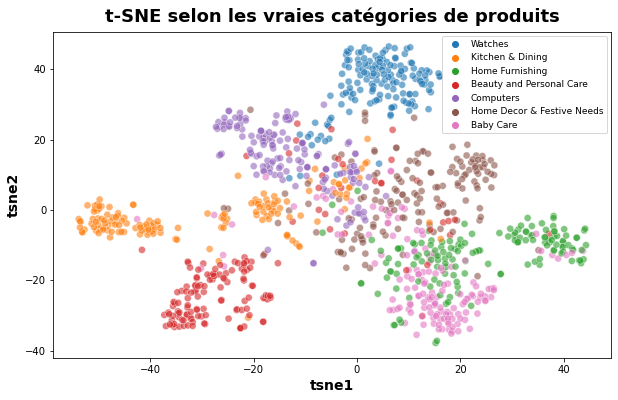

In [127]:
# Affichage des données du t-SNE selon les vraies catégories de produits
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="_main_category", data=df_tsne_VGG16, legend='brief',
    palette=sns.color_palette('tab10', n_colors=len(main_categ_list)), 
    s=50, alpha=0.6
    )

plt.title('t-SNE selon les vraies catégories de produits', fontsize = 18, pad = 10, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
plt.legend(prop={'size': 9},loc='best') 

plt.show()

L'analyse visuelle nous permet de distinguer une séparation partielle des catégories de produits.

### Création de clusters à partir du T-SNE et affichage des images selon clusters

In [128]:
 # Détermination des clusters à partir des données Tsne 
cls_vgg16 = KMeans(n_clusters=len(main_categ_list),n_init=100, random_state=42)
cls_vgg16.fit(X_tsne_VGG16)
df_tsne_VGG16['cluster'] = cls_vgg16.labels_

C:\Users\Léa Zadikian\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [129]:
df_tsne_VGG16

tsne1      tsne2                        image_name_jpg  \
0      6.509724  26.712286  009099b1f6e1e8f893ec29a7023153c4.jpg   
1     -2.278659   8.413411  0096e89cc25a8b96fb9808716406fe94.jpg   
2      6.566978 -17.477728  00cbbc837d340fa163d11e169fbdb952.jpg   
3    -20.298014 -21.490110  00d84a518e0550612fcfcba3b02b6255.jpg   
4     -2.018606  -4.440088  00e966a5049a262cfc72e6bbf68b80e7.jpg   
...         ...        ...                                   ...   
1045 -41.920219  -4.992565  feefbdff924dd6b7cc266449c9a36d69.jpg   
1046  41.603149 -14.481892  ff24511994fc459d04145231c8876d6c.jpg   
1047 -49.793613   2.970113  ffbf3794aa8cb6bb8d3f313d0a549a09.jpg   
1048  37.718952  -8.566457  ffc2e1fc7c886ec09a331040ada038aa.jpg   
1049   2.325122   9.312838  fffa2117a4006d4a848eb7d5b80d4816.jpg   

                                     image            _main_category  \
0     009099b1f6e1e8f893ec29a7023153c4.jpg                   Watches   
1     0096e89cc25a8b96fb9808716406fe94.jpg          Kitchen & Dining   
2     00cbbc837d340fa163d11e169fbdb952.jpg           Home Furnishing   
3     00d84a518e0550612fcfcba3b02b6255.jpg  Beauty and Personal Care   
4     00e966a5049a262cfc72e6bbf68b80e7.jpg                 Computers   
...                                    ...                       ...   
1045  feefbdff924dd6b7cc266449c9a36d69.jpg          Kitchen & Dining   
1046  ff24511994fc459d04145231c8876d6c.jpg           Home Furnishing   
1047  ffbf3794aa8cb6bb8d3f313d0a549a09.jpg          Kitchen & Dining   
1048  ffc2e1fc7c886ec09a331040ada038aa.jpg           Home Furnishing   
1049  fffa2117a4006d4a848eb7d5b80d4816.jpg                 Computers   

      _main_category_num  cluster  
0                      6        4  
1                      5        2  
2                      4        5  
3                      1        6  
4                      2        2  
...                  ...      ...  
1045                   5        1  
1046                   4        0  
1047                   5        1  
1048                   4        0  
1049                   2        2  

[1050 rows x 7 columns]

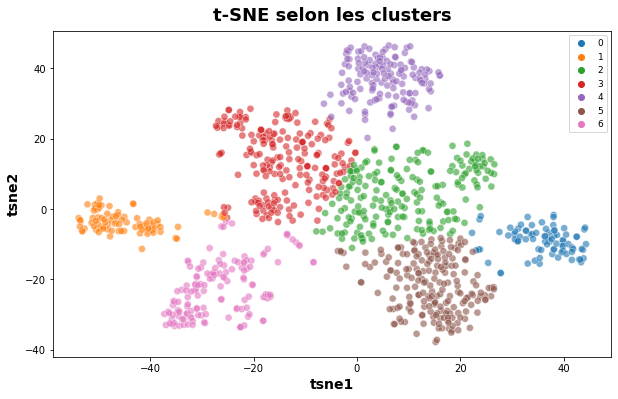

In [130]:
# Affichage des produits selon les clusters
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",hue='cluster',
    palette=sns.color_palette('tab10', n_colors=len(main_categ_list)), 
    s=50, alpha=0.6,
    data=df_tsne_VGG16,
    legend="brief")

plt.title('t-SNE selon les clusters', fontsize = 18, pad = 10, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
plt.legend(prop={'size': 9}) 

plt.show()


In [131]:
# Calcul du score ARI
ARI_VGG16 =  np.round(metrics.adjusted_rand_score(df_tsne_VGG16["_main_category_num"].values, cls_vgg16.labels_),4)
print("Score ARI : ",ARI_VGG16)

Score ARI :  0.4903


Le score ARI obtenu à l'aide de l'approche VGG-16 est environ 10 fois plus grand que le score ARI de l'approche SIFT ( qui état autour de 0.055).
L'approche CNN transfer learning permet une distinction des catégories.

**CONCLUSION :**
* L’analyse graphique montre visuellement qu’il est réalisable de séparer automatiquement les produits selon leurs vraies catégories, à l’aide de leur nom et description, et des images.
* Le calcul du score ARI a permis de confirmer l’analyse visuelle.
* Cela démontre donc la faisabilité de réaliser ultérieurement une classification pour déterminer automatiquement les images.
* Cette étude de faisabilité représente la première étape d’une démarche agile d’un projet data. 
* L’étape suivante serait de réaliser une classification supervisée avec un nombre plus important de produits, avec une recherche du modèle le plus performant et de déployer une API pour rendre disponible le modèle de classification.
